### PDF Parser - SmolDocling

In [ ]:
# Load libraries
import os
import json
from tqdm import tqdm
import mlx.core as mx
from typing import Union
from mlx_vlm import load
from pathlib import Path
import concurrent.futures
from pdf2image import convert_from_path
from mlx_vlm.prompt_utils import apply_chat_template
from mlx_vlm.utils import load_config, stream_generate
from docling_core.types.doc import ImageRefMode
from docling_core.types.doc.document import DocTagsDocument, DoclingDocument

/Users/enb/Project/freelance/nan-medium-material/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
# Set device runtime - gpu
# NOTE: On M1 CPU runtime not supported yet due maximal float type is float32 eval, model required higher float type such as float64.
os.environ["TOKENIZERS_PARALLELISM"] = "false"
mx.set_default_device(mx.gpu)

In [3]:
# Load model smoldocling
model_path = "ds4sd/SmolDocling-256M-preview-mlx-bf16"
model, processor = load(model_path)

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 200463.06it/s]


In [4]:
# Check parameter --- each key has its own QKV and trained weight.
for key in model.parameters().keys():
    print(key)
    print(model.parameters()[key].keys())
    print()

vision_model
dict_keys(['embeddings', 'encoder', 'post_layernorm'])

language_model
dict_keys(['embed_tokens', 'layers', 'norm', 'lm_head'])

connector
dict_keys(['modality_projection'])



In [5]:
# Set mlx-core with model config
model.eval()
mx.eval(model.parameters())
config = load_config(model_path)

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 206537.70it/s]


In [6]:
# Define global variable
MAX_WORKERS = 8

In [10]:
# Create utilities function
def process_single_page(args):
    """
    Process a single page with SmolDocling.
    
    Args:
        args: Tuple containing (image, model, processor, formatted_prompt, page_num)
    
    Returns:
        Tuple of (page_num, output, image)
    """
    image, model, processor, _, formatted_prompt, page_num = args
    
    output = ""
    for token in stream_generate(
        model, processor, formatted_prompt, [image], max_tokens=4096, verbose=False
    ):
        output += token.text
        if "</doctag>" in token.text:
            break
    
    return page_num, output, image

def process_pdf(pdf_path: Union[str, Path], model=None, processor=None, config=None) -> DoclingDocument:
    """
    Process a PDF file and return a DoclingDocument.
    
    Args:
        pdf_path: Path to the PDF file
        model: Optional pre-loaded model
        processor: Optional pre-loaded processor
        config: Optional pre-loaded config
    
    Returns:
        DoclingDocument object containing the processed content
    """
    # Convert PDF to images
    images = convert_from_path(str(pdf_path))
    
    # Set up the prompt
    prompt = "Convert this page to docling."
    formatted_prompt = apply_chat_template(processor, config, prompt, num_images=1)
    
    # Process each image and generate output
    all_outputs = []
    all_images = []
    
    print(f"Processing PDF: {pdf_path}")
    print(f"Total pages: {len(images)}")

    # Sequential processing
    for i, image in enumerate(images):

        print(f"Processing page {i+1}/{len(images)}...")
        all_images.append(image)
        
        # Blocking
        # output = generate(
        #     model, processor, formatted_prompt, [image], max_tokens=8192, verbose=True
        # )

        # Streaming
        output = ""
        for token in stream_generate(
            model, processor, formatted_prompt, [image], max_tokens=8192, verbose=False
        ):
            output += token.text
            if "</doctag>" in token.text:
                break
        
        all_outputs.append(output)

    # # Prepare arguments for parallel processing
    # process_args = [
    #     (image, model, processor, config, formatted_prompt, i)
    #     for i, image in enumerate(images)
    # ]
    
    # # Process pages in parallel
    # all_outputs = [""] * len(images)  # Pre-allocate list
    # all_images = [None] * len(images)  # Pre-allocate list
    
    # with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    #     futures = [executor.submit(process_single_page, args) for args in process_args]
    #     for future in tqdm(
    #         concurrent.futures.as_completed(futures),
    #         total=len(images),
    #         desc="Processing pages",
    #         unit="page"
    #     ):
    #         page_num, output, image = future.result()
    #         all_outputs[page_num] = output
    #         all_images[page_num] = image
    
    # Create DoclingDocument
    doctags_doc = DocTagsDocument.from_doctags_and_image_pairs(all_outputs, all_images)
    doc = DoclingDocument(name=Path(pdf_path).stem)
    doc.load_from_doctags(doctags_doc)
    
    return doc

def save_document(doc: DoclingDocument, output_path: Union[str, Path], format: str = "markdown"):
    """
    Save the processed document in the specified format.
    
    Args:
        doc: DoclingDocument to save
        output_path: Path where to save the output
        format: Output format ('markdown', 'html', or 'json')
    """
    output_path = Path(output_path)
    
    # Create directory if it doesn't exist
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    print(f"Saving output as {format} to: {output_path}")
    
    if format.lower() == "markdown":
        result = doc.export_to_markdown()
        output_path = output_path.with_suffix(".md")
        with open(output_path, "w", encoding="utf-8") as f:
            f.write(result)
    
    elif format.lower() == "html":
        doc.save_as_html(output_path.with_suffix(".html"), image_mode=ImageRefMode.EMBEDDED)
    
    elif format.lower() == "json":
        doc_dict = doc.export_to_dict()
        with open(output_path.with_suffix(".json"), "w", encoding="utf-8") as f:
            json.dump(doc_dict, f, indent=4)
    
    else:
        raise ValueError(f"Unsupported format: {format}")

In [11]:
# Define example PDF path
pdf_path = "../dataset/cybersecurity-report/bcs-insights-report-2021.pdf"
output_path = "output"

In [12]:
# Process the pdf document
doc = process_pdf(pdf_path, model, processor, config)

# NOTE:
# Memory swap allocation spent 6-9GB and memory allocation spent around 3GB.

# ERROR: 
# PDFInfoNotInstalledError: Unable to get page count. Is poppler installed and in PATH?
# Solution -> brew install poppler

Processing PDF: ../dataset/cybersecurity-report/bcs-insights-report-2021.pdf
Total pages: 34
Processing page 1/34...


/Users/enb/Project/freelance/nan-medium-material/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Processing page 2/34...
Processing page 3/34...
Processing page 4/34...
Processing page 5/34...
Processing page 6/34...
Processing page 7/34...
Processing page 8/34...
Processing page 9/34...
Processing page 10/34...
Processing page 11/34...
Processing page 12/34...
Processing page 13/34...
Processing page 14/34...
Processing page 15/34...
Processing page 16/34...
Processing page 17/34...
Processing page 18/34...
Processing page 19/34...
Processing page 20/34...
Processing page 21/34...
Processing page 22/34...
Processing page 23/34...
Processing page 24/34...
Processing page 25/34...
Processing page 26/34...
Processing page 27/34...
Processing page 28/34...
Processing page 29/34...
Processing page 30/34...
Processing page 31/34...
Processing page 32/34...
Processing page 33/34...
Processing page 34/34...


In [13]:
# Save the output
save_document(doc, output_path, format="markdown")

Saving output as markdown to: output


In [14]:
# Save the output
save_document(doc, output_path, format="html")

Saving output as html to: output


In [15]:
# Save the output
save_document(doc, output_path, format="json")

Saving output as json to: output


### Self Corrective RAG - LangGraph

In [125]:
# Load libraries
import os
import json
import operator
from dotenv import load_dotenv

from langgraph.graph import END
from langchain_groq import ChatGroq
from langchain.schema import Document
from langgraph.graph import StateGraph
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.vectorstores import SKLearnVectorStore
from lettucedetect.models.inference import HallucinationDetector
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders.markdown import UnstructuredMarkdownLoader

from typing import List, Annotated
from warnings import filterwarnings
from typing_extensions import TypedDict
from IPython.display import display, Markdown, clear_output, Image

load_dotenv("../.env")
filterwarnings("ignore")

In [126]:
# Setup view markdown function
def display_md(text):
    clear_output()
    display(Markdown(text))

# Post-processing function to format documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [162]:
# Set environment variable
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

MAX_RETRIES = 3
TEMPERATURE = 0.5
# GROQ_MODEL_NAME = os.getenv("GROQ_MODEL_NAME", "llama-3.3-70b-versatile")
GROQ_MODEL_NAME = "llama3-70b-8192"

In [163]:
# Setup LLM

## Initialize ChatGroq with specified model and parameters
llm = ChatGroq(
    model=GROQ_MODEL_NAME,
    temperature=TEMPERATURE,
    max_tokens=None,
    timeout=None,
    max_retries=MAX_RETRIES
)

## Initialize ChatGroq with JSON response format
llm_json_mode = ChatGroq(
    model=GROQ_MODEL_NAME,
    temperature=TEMPERATURE,
    max_tokens=None,
    timeout=None,
    max_retries=MAX_RETRIES,
    response_format={"type": "json_object"},
)

In [5]:
# Load markdown file
document = [UnstructuredMarkdownLoader("output.md").load()]

In [6]:
# preview sample structure document
document[0]

[Document(metadata={'source': 'output.md'}, page_content='BCS Insights 2021\n\nCONTENTS\n\n03\n\nINTRODUCTION\n\n04 DIVERSITY 2021: SLOW PROGRESS IS SOME PROGRESS\n\n07 Key ONS findings, gender\n\n08 Key ONS findings, age\n\n09 Key ONS findings, disability\n\n10 Key ONS findings, ethnicity\n\n12 IT LEADERS\n\n17 Key findings, IT Leaders\n\n18 CYBER SECURITY: SECURITY SPIDER SENSE\n\n18 Key findings, Cyber security\n\n24 ETHICAL DILEMMAS\n\n26 SUSTAINABLE COMPUTING\n\n30 SHORT AND SHARP SURVEYS\n\nINTRODUCTION\n\nWelcome to our third annual Insights event. It was in 2019 that we debuted this highly successful new event, designed to give a platform for interesting and provocative thinking relating to technology and to showcase our research insights. In 2020 we went virtual, for obvious reasons, and this continues with our 2021 event.\n\nBCS\'s aim to make IT good for society has never been more important - and the pandemic has only made that more obvious. Alongside this is the evergrowin

In [7]:
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,
    chunk_overlap=100
)
doc_splits = text_splitter.split_documents(document[0])

In [8]:
# Check length
len(doc_splits)

37

In [9]:
# Load embedding model
EMBEDDING_MODEL_NAME="Snowflake/snowflake-arctic-embed-l-v2.0"
embedding = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME, show_progress=True)

In [10]:
embedding

HuggingFaceEmbeddings(model_name='Snowflake/snowflake-arctic-embed-l-v2.0', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=True)

In [11]:
# Setup Vectorstore

## SKLearnVectorStore is used to store and retrieve document embeddings for similarity search
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding
)

## Create a retriever to fetch top 5 similar documents
retriever = vectorstore.as_retriever(k=5)

Batches: 100%|██████████| 2/2 [00:45<00:00, 22.94s/it]


In [12]:
# Prompt instructions for routing user questions
router_instructions = """
    You are an expert at routing a user question to either a `vectorstore` or a `web search`.
    
    The vectorstore contains documents related to IT and technology, including but not limited to:
    - Cybersecurity (e.g., threats, cloud security concerns, incident responses)
    - Diversity and inclusion in IT (e.g., gender, age, ethnicity, disability representation)
    - Ethical dilemmas in IT (e.g., professional ethics, data privacy, ethical trade-offs)
    - Sustainable computing (e.g., green IT practices, ESG goals, government and IT roles)
    - IT leadership trends (e.g., business continuity, cloud adoption, remote work challenges)
    - Broader societal impacts of technology (e.g., digital skills gaps, AI regulation, social media accountability)
    
    Use the vectorstore for questions that align with the above topics and are likely to be covered in the BCS Insights 2021 report or similar IT-focused content.
    
    Use web-search for:
    - Questions about current events or recent developments not covered in the vectorstore.
    - Topics outside the scope of IT, cybersecurity, diversity, ethics, or sustainability as described above.
    - Queries requiring real-time information, such as statistics or updates post-2021.
    
    Return JSON with a single key, `datasource`, which should be either 'websearch' or 'vectorstore', depending on the question.
"""

# Define test question
test_questions = [
    ("What is the main goal of BCS as stated in the introduction?", "vectorstore"),
    ("What percentage of IT specialists in the UK workforce were female in 2020?", "vectorstore"),
    ("What are the biggest cyber threats listed in the report?", "vectorstore"),
    ("What are the latest vulnerabilities disclosed in the past 24 hours?", "websearch"),
    ("Compare CrowdStrike Falcon and Microsoft Defender pricing?", "websearch"),
    ("What new zero-day exploits were reported this week?", "websearch"),
    ("Evaluate the role of government in regulating the IT industry's ethical standards as suggested by the survey respondents.", "vectorstore"),
    ("What are the current trends in ransomware attacks?", "websearch")
]

for index, (question, expected_result) in enumerate(test_questions):
    test_result = llm_json_mode.invoke(
        [
            SystemMessage(content=router_instructions),
            HumanMessage(content=question)
        ]
    )
    route = json.loads(test_result.content)['datasource']
    print(f"Case {index}: {'success' if route == expected_result else 'failed'}\ndetails: {route}")
    print()

Case 0: success
details: vectorstore

Case 1: success
details: vectorstore

Case 2: success
details: vectorstore

Case 3: success
details: websearch

Case 4: success
details: websearch

Case 5: success
details: websearch

Case 6: success
details: vectorstore

Case 7: success
details: websearch



In [13]:
# Instructions for the document grader
doc_grader_instructions = """
    You are a grader assessing relevence of a retrieved document to a user question.
    If the document contains keyword(s) or sementic meaning related to the question, grade it as relevant.
"""

# Grader prompt
doc_grader_prompt = """**Here is the retrieved document:** \n\n {document} \n\n **Here is the user question:** \n\n {question}.\n\n
This carefully and objectively assess the document contains at least some information that is relevant to the question.
Return JSON with single key, `binary_score`, that is 'yes' or 'no' score to indicate whether the document is contains at least some information that is relevant to the question."""

# Test the document grader
question = "What is the main goal of BCS as stated in the introduction?"
docs = retriever.invoke(question)
doc_text = docs[1].page_content

# Format the grader prompt with the retrieved document and the question
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_text, question=question
)

Batches: 100%|██████████| 1/1 [00:07<00:00,  7.98s/it]


In [14]:
# Overview result
display_md(doc_grader_prompt_formatted)

**Here is the retrieved document:** 

 'Help empower BCS members with data to support arguments. Include a cost saving to incentivise corporates to change, whilst enjoying positive PR for working to combat climate change:

'Highlight how emerging tech can help.'

Facilitate a public discussion, challenge technology directions/ trends that are contrary to environmental objectives, and highlight lazy claims (for example, that 'carbon offsetting' by planting trees doesn't negate the carbon impact, it just defers it)'

'Ensure it uses the tech itself as a showcase and example for others to follow. Link up with key areas of academia so that it can speak with one voice on the latest and proven ideas. Link up closely with government to understand political factors which might impact its technical focussed message - so that hopefully the government can start relying on BCS (and other professional bodies) to provide detailed technical advice to inform its initiatives.'

'Avoid politicisation of the debate. Stick only to verifiable truths. Be a source of dispassionate, scientific data and information.'

'Make information available. ( "Did you know that you could...") implement awards and prizes. Humans are motivated by competitions and prizes, not some 560-page specification. The rewards don't have to be large.'

HIGHLIGHT HOW EMERGING TECH CAN HELP.'

'Open the door to innovators, new designers and emerging technologists (many of whom are young and female) and amplify their voice.'

This report was generated on 07/06/21. Overall 441 respondents took part in the survey during the period 11 May to 6 June 2021.

SOME PRACTICAL BITS

In keeping with the theme of Insights -to do good as well as define it -some members came up with practical suggestions.

For example:

'Manufacturers could join up in power supplies. I've got thousands of different ones from all the different brands.'

'Lower power client devices such as Apple's new M1 CPUs Cloud computing, centralising more power consumption so it can be measured, offset and made cleaner.'

'Use performance engineering practices that make software run more efficiently. There are programming languages that have built in an optimising computer to achieve optimal efficiency on a variety of hardware architectures. Investing in teams to continually optimise the products and services.' 

 **Here is the user question:** 

 What is the main goal of BCS as stated in the introduction?.


This carefully and objectively assess the document contains at least some information that is relevant to the question.
Return JSON with single key, `binary_score`, that is 'yes' or 'no' score to indicate whether the document is contains at least some information that is relevant to the question.

In [15]:
# Get the grading result
result = llm_json_mode.invoke(
    [
        SystemMessage(content=doc_grader_instructions),
        HumanMessage(content=doc_grader_prompt_formatted)
    ]
)

# Parse and display the result
json.loads(result.content)

{'binary_score': 'yes'}

In [16]:
# Prompt for the retrieval-augmented generation (RAG) model
rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:
{context}
\nThink carefully about the context.

Now, review the user question:
{question}

Provide an answer to this question using only the above context.
Use three sentences maximum and keep the answer concise.

Answer:
"""

# Test the RAG model with a question
docs = retriever.invoke(question)
docs_txt = format_docs(docs)

# Format the RAG prompt with the retrieved documents and the question
rag_prompt_formatted = rag_prompt.format(
    context=docs_txt,
    question=question
)

# Generate the answer using the RAG model
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


In [17]:
# Display the generated answer as Markdown
display_md(generation.content)

The main goal of BCS is not explicitly stated in the introduction, but it can be inferred that BCS aims to promote IT professionalism and ethics. The introduction highlights the importance of BCS training in making members aware of illegal activities and promoting ethical behavior. The report appears to focus on how BCS can support its members in promoting sustainable computing and IT practices.

In [18]:
# Hallucination grader instructions
hallucination_grader_instructions = """You are a teacher grading a quiz.
You will be given `FACTS` and `STUDENT ANSWER`.\n\n

Here is the grade criteria:\n
1. Ensure the `STUDENT ANSWER` is grounded in the `FACTS`
2. Ensure the `STUDENT ANSWER` does not contain "hallucinated" information outside the scope of the `FACTS`.\n\n

Score:
"""

# Grader prompt for hallucination detection
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: \n\n {generation}. \n\n
Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` is grounded in the `FACTS`, and `explanation` which contains an explanation of the score."""

# Test the hallucination grader using the documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt,
    generation=generation.content
)

result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)

In [19]:
# Parse and display the result
print(json.dumps(json.loads(result.content), indent=4))

{
    "binary_score": "yes",
    "explanation": "The student answer is grounded in the facts as it accurately infers the main goal of BCS and highlights the importance of BCS training in promoting ethical behavior and sustainable computing practices, all of which are supported by the provided facts."
}


In [20]:
# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz.
You will be given `QUESTION` and a `STUDENT ANSWER`.\n\n

Here is the grade criteria to follow:
1. The `STUDENT ANSWER` helps to answer the `QUESTION`

Score:\n
A score of `yes` means that the student's answer meets all of the criteria. This is the `highest (best)` score.
The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.
A score of `no` means that the student's answer does not meet all of the criteria. This is the `lowest` possible score you can give.
Explain your reasoning in a step by step manner to ensure your reasoning and conclusion are correct.
Avoid simply stating the correct answer at the outset."""

# Grader prompt for answer grading
answer_grader_prompt = """QUESTION: \n\n {question} \n\nSTUDENT ANSWER:\n\n{generation} \n\n
Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` meets the criteria, and `explanation` which contains an explanation of the score."""

# Test using the question and generation from above
answer = generation.content
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question,
    generation=answer
)

result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)

In [21]:
# Parse and display the result
print(json.dumps(json.loads(result.content), indent=4))

{
    "binary_score": "yes",
    "explanation": "The student answer attempts to address the question by inferring the main goal of BCS from the introduction, even though it is not explicitly stated. The student provides relevant information about promoting IT professionalism and ethics, and highlights the importance of BCS training in promoting ethical behavior. This shows that the student's answer helps to answer the question, meeting the criteria."
}


In [74]:
# Initialize the web search tool with top 3 search results
web_search_tool = TavilySearchResults(k=3)

In [164]:
# Create Graph State
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in,
    each node
    """
    
    question: str
    generation: str
    web_search: str
    max_retries: int
    answers: int
    loop_step: Annotated[int, operator.add]
    documents: List[str]

def retrieve(state):
    """
    Retrieve documents from vectorstore
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    
    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(
        context=docs_txt,
        question=question
    )
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    
    return {
        "generation": generation,
        loop_step: loop_step + 1
    }

def grade_documents(state):
    """
    Determine whether the retrieved documents are relevant to the question
    If any document is not relevent, we will set a flag to run web search
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_serarch state
    """
    
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # score each doc
    filtered_docs = []
    
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document = d.page_content,
            question=question
        )
        
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        
        grade = json.loads(result.content)["binary_score"]
        
        # document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)

        # TODO: Create decision with "any" condition, that only searching via website IF there is not "relevant document" / setup fallback handler such as "Im Sorry, I dont know."
        # document not relevant, set web searching.
        # else:
        #     print("---GRADE: DOCUMENT NOT RELEVANT---")
        #     web_search = "Yes"
        #     continue
    
    return {
        "documents": filtered_docs,
        "web_search": web_search
    }

def web_search(state):
    """
    Web search based on the question
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Appended web results to documents
    """
    
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    
    # web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents}

def route_question(state):
    """
    Route question to web search or RAG
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Next node to call
    """
    
    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    else:
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    
    if web_search == "Yes":
        # all documents have been filtered check_relevance
        # we will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        
        return "web_search"
    else:
        # we have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Decision for next node to call
    """
    
    print("---CHECK HALUCINATIONS")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # default to 3 if not provided
    
    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents = format_docs(documents),
        generation = generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]
    
    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        
        # test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question,
            generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        
        grade = json.loads(result.content)["binary_score"]
        
        if grade == "yes":
            print("---DECISION: GENERATION ANSWERS QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

### Control Flow

In [165]:
# Initialize the workflow with the GraphState
workflow = StateGraph(GraphState)

# define the nodes
workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

In [166]:
# build graph
workflow.set_conditional_entry_point(
    route_question, # route the question to web search or vectorstore
    {
        "websearch": "websearch", # if question needs web search
        "vectorstore": "retrieve", # if question can be answered from vectorstore
    },
)

# add edges between nodes
workflow.add_edge("websearch", "generate") # after web search, generate answer
workflow.add_edge("retrieve", "grade_documents") # after retrieval, grade docs

# conditional edge after grading docs
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch", # if docs not relevant, do web search
        "generate": "generate", # if docs relevant, generate answer
    },
)

# conditional edge after generating answer
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate", # regenerate if not supported
        "useful": END, # end if answer useful
        "not useful": "websearch", # web search if not useful
        "max retries": END, # end if max retries reached
    },
)

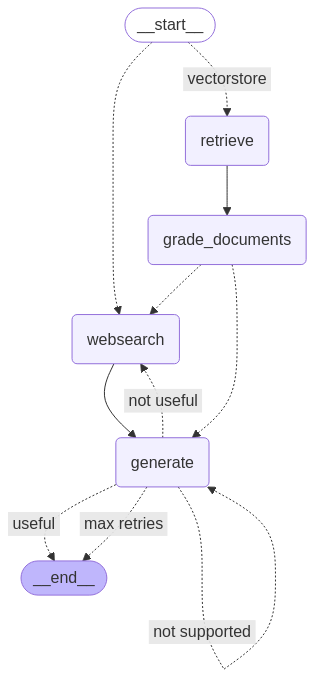

In [167]:
# Compile the workflow graph
graph = workflow.compile()

# Display the compiled graph as an image
display(Image(graph.get_graph().draw_mermaid_png()))

In [86]:
# Define inputs for the workflow
inputs = {
    "question": "Critically assess the suggestions made by IT professionals for promoting sustainable computing practices.", 
    "max_retries": 3
}

In [36]:
# Generate answer result
result = graph.invoke(input=inputs)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.71s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


In [37]:
result

{'question': 'Critically assess the suggestions made by IT professionals for promoting sustainable computing practices.',
 'generation': AIMessage(content='IT professionals suggested various ways to promote sustainable computing practices, including subsidising and incentivising eco-friendly behaviour, improving connectivity, and promoting the use of flow battery technology to balance the grid and make better use of renewables. Some also recommended taxing tech giants, regulating them to prevent the spread of fake news, and recognising the BCS as an authoritative voice on sustainable IT practices. Additionally, professionals suggested that the government should outlaw digital currencies, promote video conferencing, and apply a clear disincentive to drive, making it more expensive to travel and easier to access virtual meetings.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 116, 'prompt_tokens': 1872, 'total_tokens': 1988, 'completion_time': 0.421818182

In [ ]:
# Stream events from the compiled graph
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'Critically assess the suggestions made by IT professionals for promoting sustainable computing practices.', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


{'question': 'Critically assess the suggestions made by IT professionals for promoting sustainable computing practices.', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': 'a79a9eee-7f35-4530-8d38-c432bf512aa1', 'source': 'output.md'}, page_content="KEY FINDINGS\n\n· 40% of participants indicated that IT is used to meet their organisation's ESG goals. 21% suggested that IT isn't used for this, and the rest were either neutral or their organisation did not have an ESG policy.\n\n· 59% of respondents feel empowered as an IT professional to speak up on greener and more ethical alternatives in their organisation's tech strategy.\n\n· Nearly half of those questioned (45%) think that the government should be the main driver of a roadmap for IT and digital technologies that helps to achieve a greener, more sustainable society. The second choice, relevant professional bodies, scored 18%.\n\nAnd on a more specialised note: 'The data and analytics derived through satellite

In [28]:
event

{'question': 'Critically assess the suggestions made by IT professionals for promoting sustainable computing practices.',
 'generation': AIMessage(content='IT professionals suggested various ways to promote sustainable computing practices, including subsidising and incentivising eco-friendly behaviour, improving connectivity, and promoting the use of flow battery technology to balance the grid and make better use of renewables. Some also recommended taxing tech giants, regulating them to prevent the spread of fake news, and recognising the BCS as an authoritative voice on sustainable IT practices. Additionally, professionals suggested that the government should outlaw digital currencies, promote video conferencing, and apply disincentives to driving to encourage more sustainable practices.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 106, 'prompt_tokens': 1872, 'total_tokens': 1978, 'completion_time': 0.385454545, 'prompt_time': 0.127956931, 'queue_ti

In [30]:
print(json.dumps(event['generation'].model_dump(), indent=4))

{
    "content": "IT professionals suggested various ways to promote sustainable computing practices, including subsidising and incentivising eco-friendly behaviour, improving connectivity, and promoting the use of flow battery technology to balance the grid and make better use of renewables. Some also recommended taxing tech giants, regulating them to prevent the spread of fake news, and recognising the BCS as an authoritative voice on sustainable IT practices. Additionally, professionals suggested that the government should outlaw digital currencies, promote video conferencing, and apply disincentives to driving to encourage more sustainable practices.",
    "additional_kwargs": {},
    "response_metadata": {
        "token_usage": {
            "completion_tokens": 106,
            "prompt_tokens": 1872,
            "total_tokens": 1978,
            "completion_time": 0.385454545,
            "prompt_time": 0.127956931,
            "queue_time": 0.24341102400000003,
            "tot

In [31]:
# Question: Critically assess the suggestions made by IT professionals for promoting sustainable computing practices.
display_md(event['generation'].model_dump()['content'])

IT professionals suggested various ways to promote sustainable computing practices, including subsidising and incentivising eco-friendly behaviour, improving connectivity, and promoting the use of flow battery technology to balance the grid and make better use of renewables. Some also recommended taxing tech giants, regulating them to prevent the spread of fake news, and recognising the BCS as an authoritative voice on sustainable IT practices. Additionally, professionals suggested that the government should outlaw digital currencies, promote video conferencing, and apply disincentives to driving to encourage more sustainable practices.

## Orchestration Benchmarking

In [168]:
# Load libraries
import time
import traceback
import pandas as pd
from tqdm import tqdm
from typing import Dict, Union

In [169]:
# Load hallucination detector model
detector = HallucinationDetector(
    method="transformer", model_path="KRLabsOrg/lettucedect-base-modernbert-en-v1"
)

In [170]:
# Define list of questions (minimal 10 question.)
list_questions = [
    "How does the underrepresentation of ethnic minorities in specific IT roles, such as Specialist IT Managers (12%) compared to Business Analysts (26%), reflect broader systemic issues within the IT industry's recruitment and retention practices?",
    "Given that only 42% of respondents believe their senior leadership teams have sufficient skills to manage cyber risk, what comprehensive strategies could organizations implement to bridge this knowledge gap while addressing the growing concerns about cloud vulnerabilities and third-party infrastructure?",
    "In what ways might the shift towards remote working, accelerated by the pandemic, disproportionately affect older IT specialists (aged 50+), considering their higher likelihood of holding responsible positions but also facing higher unemployment rates compared to younger counterparts?",
    "Considering that 61% of IT professionals feel empowered to speak up about greener alternatives, yet only 40% indicate IT is actively used to meet ESG goals, what structural or cultural barriers might exist within organizations that prevent the translation of ethical intentions into actionable sustainability initiatives?",
    "How can the IT industry address the dual challenge of increasing representation of people with disabilities (currently at 10%) while also ensuring equitable access to job-related education and training opportunities, given that 30% of IT specialists with disabilities received training compared to 23% without disabilities?",
    "With nearly half (49%) of cybersecurity respondents expressing concern about the shift to third-party cloud computing, how should IT leaders balance the benefits of cloud adoption with the potential risks, particularly regarding compliance with regulations like GDPR, Schrems II, and DPA (2018)?",
    "What are the ethical considerations regarding AI and data mentioned in the ethical dilemmas section, and how do they intersect with diversity concerns? What role can professional bodies like BCS play in fostering both ethical practices and inclusive work environments?",
    "What implications does the significant gender disparity in IT degree attainment (6% of female IT specialists vs. 14% of male IT specialists) have for long-term career progression and leadership opportunities for women in IT, and how can educational institutions and employers collaborate to close this gap?",
    "Analyze the potential consequences of the UK losing control over significant digital tech companies like ARM, given that 95% of IT professionals consider retaining ownership crucial, and discuss how this aligns with concerns about AI development and its societal impacts.",
    "Evaluate the effectiveness of current measures to combat online abuse through real ID verification on social media platforms, taking into account the technical feasibility (56% believe it’s achievable), privacy concerns raised by BCS members, and the broader implications for free speech and digital rights."
]

In [171]:
def evaluate_orchestration(questions: List[str], max_retries: int = 3) -> Dict[str, Union[int, float, str, bool]]:
    result_evaluation = {
        "question": [],
        "answer": [],
        "token_input": [],
        "token_output": [],
        "latency": [],
        "max_retries": [],
        "is_web_search": [],
        "hallucation_score": []
    }
    for question in tqdm(questions, desc="Evaluation"):
        try:
            start_time = time.time()
            result_graph = graph.invoke(
                {
                    "question": question,
                    "max_retries": max_retries
                }
            )
            end_time = time.time() - start_time

            metadata_answer = result_graph["generation"].model_dump()
            contexts = result_graph["documents"]
            answer = metadata_answer["content"]

            confidence_score = 0.0
            for context in contexts:
                evaluation = detector.predict(
                    context=context.page_content, 
                    question=question, 
                    answer=answer, 
                    output_format="spans"
                )
                if len(evaluation) == 0:
                    continue
                confidence_score = evaluation[0]["confidence"]
                
            result_evaluation["question"].append(question)
            result_evaluation["answer"].append(answer)
            result_evaluation["token_input"].append(metadata_answer["usage_metadata"]["input_tokens"])
            result_evaluation["token_output"].append(metadata_answer["usage_metadata"]["output_tokens"])
            result_evaluation["latency"].append(end_time)
            result_evaluation["max_retries"].append(result_graph["max_retries"])

            if "web_search" in result_graph:
                result_evaluation["is_web_search"].append(result_graph["web_search"])
            else:
                result_evaluation["is_web_search"].append("No")
            
            result_evaluation["hallucation_score"].append(confidence_score)
            
        except Exception as _:
            traceback.print_exc()
            continue

        # Prevent rate limit Groq - free service.
        time.sleep(15)

    return result_evaluation

In [172]:
# TODO: ...
# Question | Answer | Total Input Token | Total Output Token | Latency | Max Retries | Web Search | Hallucation Score

In [173]:
# Perform benchmarking
benchmark_evaluation = evaluate_orchestration(questions=list_questions)

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


Token indices sequence length is longer than the specified maximum sequence length for this model (14795 > 8192). Running this sequence through the model will result in indexing errors


---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  10%|█         | 1/10 [01:10<10:32, 70.32s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  20%|██        | 2/10 [02:35<10:33, 79.22s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:10<00:00, 10.91s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  30%|███       | 3/10 [03:53<09:09, 78.57s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.46s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  40%|████      | 4/10 [05:03<07:30, 75.05s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  50%|█████     | 5/10 [06:24<06:26, 77.23s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  60%|██████    | 6/10 [07:38<05:05, 76.27s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  70%|███████   | 7/10 [08:36<03:31, 70.38s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  80%|████████  | 8/10 [09:48<02:21, 70.68s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation:  90%|█████████ | 9/10 [10:41<01:05, 65.19s/it]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALUCINATIONS
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---


Evaluation: 100%|██████████| 10/10 [11:40<00:00, 70.07s/it]


In [175]:
# Wrap into dataframe
df_evaluation = pd.DataFrame.from_dict(benchmark_evaluation)
df_evaluation

,question,answer,token_input,token_output,latency,max_retries,is_web_search,hallucation_score
0,How does the underrepresentation of ethnic min...,The underrepresentation of ethnic minorities i...,1988,102,24.634001,3,No,0.0
1,Given that only 42% of respondents believe the...,"To bridge the knowledge gap, organizations cou...",1915,103,31.204552,3,No,0.0
2,In what ways might the shift towards remote wo...,The shift towards remote working may dispropor...,2024,103,28.742988,3,No,0.0
3,Considering that 61% of IT professionals feel ...,"According to the report, a lack of information...",1867,104,14.925422,3,No,0.0
4,How can the IT industry address the dual chall...,"To address the dual challenge, the IT industry...",2073,112,27.635605,3,No,0.0
5,With nearly half (49%) of cybersecurity respon...,IT leaders should prioritize setting consisten...,1956,96,19.405991,3,No,0.0
6,What are the ethical considerations regarding ...,The ethical considerations regarding AI and da...,1474,110,15.151057,3,No,0.0
7,What implications does the significant gender ...,The significant gender disparity in IT degree ...,1592,101,28.377139,3,No,0.0
8,Analyze the potential consequences of the UK l...,The potential consequences of the UK losing co...,1063,121,18.163328,3,No,0.0
9,Evaluate the effectiveness of current measures...,The effectiveness of current measures to comba...,1019,95,23.626334,3,No,0.0


![](scoring-evidence.png)

In [177]:
# Add manual scoring from qwen.
qwen_scoring = [90, 85, 75, 92, 88, 87, 90, 85, 88, 90]
df_evaluation["llm_eval"] = qwen_scoring
df_evaluation

,question,answer,token_input,token_output,latency,max_retries,is_web_search,hallucation_score,llm_eval
0,How does the underrepresentation of ethnic min...,The underrepresentation of ethnic minorities i...,1988,102,24.634001,3,No,0.0,90
1,Given that only 42% of respondents believe the...,"To bridge the knowledge gap, organizations cou...",1915,103,31.204552,3,No,0.0,85
2,In what ways might the shift towards remote wo...,The shift towards remote working may dispropor...,2024,103,28.742988,3,No,0.0,75
3,Considering that 61% of IT professionals feel ...,"According to the report, a lack of information...",1867,104,14.925422,3,No,0.0,92
4,How can the IT industry address the dual chall...,"To address the dual challenge, the IT industry...",2073,112,27.635605,3,No,0.0,88
5,With nearly half (49%) of cybersecurity respon...,IT leaders should prioritize setting consisten...,1956,96,19.405991,3,No,0.0,87
6,What are the ethical considerations regarding ...,The ethical considerations regarding AI and da...,1474,110,15.151057,3,No,0.0,90
7,What implications does the significant gender ...,The significant gender disparity in IT degree ...,1592,101,28.377139,3,No,0.0,85
8,Analyze the potential consequences of the UK l...,The potential consequences of the UK losing co...,1063,121,18.163328,3,No,0.0,88
9,Evaluate the effectiveness of current measures...,The effectiveness of current measures to comba...,1019,95,23.626334,3,No,0.0,90


In [178]:
# Export into excel --- to perform evaluation using OpenAI Website.
df_evaluation.to_excel("evaluation.xlsx", index=False)